In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
import shap

In [2]:
import lightgbm as lgbm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [3]:
from scipy import stats
import time
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

In [4]:
import create_data

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

In [5]:
import const
import transformers

# Создание и предобработка датасета

In [ ]:
df_data=create_data.create_df()

# Построение модели (используются 22 фичи)

## 1. Деление данных на 2 временных периода: 04.2016-06.2017, 07.2017-08.2018

### Берем test_2 с df_2018 (Далее используется этот вариант)

test_2 состоит из актуальных данных из промежутка (07.2017-08.2018) и содержит 2196 записей (ровно как и различные test по кросс-валидации)

In [8]:
X = df_data.loc[lambda x: x.REQUEST_DATE>='2017-07-01'].drop(['12_90'], axis=1)
Y = df_data.loc[lambda x: x.REQUEST_DATE>='2017-07-01']['12_90']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 2196, stratify=Y, random_state=5, shuffle = True)
#X_test=X_test.drop(['REQUEST_DATE'],axis=1)

In [9]:
model_param= {'model__lambda_l1': 11,
              'model__lambda_l2': 40,
              'model__learning_rate': 0.01,
              'model__max_bin': 22,
              'model__max_depth': 7,
              'model__metric': 'AUC',
              'model__min_data_in_leaf': 63,
              'model__n_estimators': 2500,
              'model__num_leaves': 134,
              'model__objective': 'binary'}

In [11]:
from sklearn.pipeline import Pipeline

preprocessor_pipe = Pipeline(steps=[('renamer', transformers.preprocessors.Renamer(const.columns.renaming_columns)),
                                    ('cleaner', transformers.preprocessors.Cleaner_columns_as_wiki(const.columns.columns_as_wiki)),
                                    ('typechanger', transformers.preprocessors.TypeСhanger(const.columns.col_transform_default_int,
                                                                                     const.columns.col_transform_default_str,
                                                                                     const.columns.col_transform_type_date, 
                                                                                     const.columns.col_transform_type_int, 
                                                                                     const.columns.col_transform_type_str,
                                                                                     const.columns.col_transform_type_float)),
                                    ('preprocessor', Preprocessor()),
                                    ('clipper' , transformers.preprocessors.Clipper(const.columns.columns_binary_clip, 
                                                                                    const.columns.columns_percent_clip, 0.98)),
                                    ('final_columns', transformers.FinalFeaturesSelector.FinalFeaturesSelector(const.columns.final_columns_model))
                                    ])

In [12]:
from sklearn.pipeline import Pipeline

my_pipeline = Pipeline(steps=[('preprocessor_pipe', preprocessor_pipe),
                              ('model', lgbm.LGBMClassifier())
                             ])

In [13]:
my_pipeline.set_params(**model_param)

Pipeline(memory=None,
         steps=[('preprocessor_pipe',
                 Pipeline(memory=None,
                          steps=[('renamer',
                                  Renamer(renaming_dict={'ALL_CLC': 'MEGAFON|ALL_CLC',
                                                         'FPS_TOTAL_AMOUNT': 'FPS|MAINRULES_COUNT',
                                                         'LIFETIME_BIN': 'MEGAFON|LIFETIME_BIN',
                                                         'LOANS_QUA_AUTO_ACTIVE': 'TTL_AUTO_ACTIVE',
                                                         'LOANS_QUA_AUTO_TOTAL': 'TTL_AUTO_ALL',
                                                         'LOANS_QUA_CC_ACTIVE': 'TTL_CREDIT_CARD_ACTIVE',
                                                         'LOAN...
                                lambda_l1=11, lambda_l2=40, learning_rate=0.01,
                                max_bin=22, max_depth=7, metric='AUC',
                                min_child_samples=2

In [25]:
# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train, model__eval_set=[(preprocessor_pipe.transform(X_test),  y_test)],
                            #eval_set=[(x_test,  y_test), (x_test_2,  y_test_2)], 
                            #eval_names=['cv', 'fixed'],
                            model__eval_metric='auc',
                            model__early_stopping_rounds=200,
                            model__verbose=-1)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2237]	valid_0's auc: 0.833837


Pipeline(memory=None,
         steps=[('preprocessor_pipe',
                 Pipeline(memory=None,
                          steps=[('renamer',
                                  Renamer(renaming_dict={'ALL_CLC': 'MEGAFON|ALL_CLC',
                                                         'FPS_TOTAL_AMOUNT': 'FPS|MAINRULES_COUNT',
                                                         'LIFETIME_BIN': 'MEGAFON|LIFETIME_BIN',
                                                         'LOANS_QUA_AUTO_ACTIVE': 'TTL_AUTO_ACTIVE',
                                                         'LOANS_QUA_AUTO_TOTAL': 'TTL_AUTO_ALL',
                                                         'LOANS_QUA_CC_ACTIVE': 'TTL_CREDIT_CARD_ACTIVE',
                                                         'LOAN...
                                lambda_l1=11, lambda_l2=40, learning_rate=0.01,
                                max_bin=22, max_depth=7, metric='AUC',
                                min_child_samples=2

In [ ]:
0.83386

In [149]:
# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_test)

# Evaluate the model
#score = roc_auc_score(y_test, preds)

## 2.Деление на train и test

Для test используются данные только из 07.2017-08.2018 промежутка, который делится на 5 фолдов, а затем 1 часть берется для теста, а остальные добавляются к 04.2016-06.2017 и образуют train.

## 2. Кросс-валидация на 5 фолдах и 20 различных random_state ==> 100 моделей
## 3. Обучение моделей

In [92]:
def my_cv(df_full, cv, fold):
    '''кастомная кросс валидация
       return datasets: x_train, y_train, x_test, y_test
    '''
    train_ind, test_ind = [], []
    df_2018=df_full.loc[lambda x: x.REQUEST_DATE>='2017-07-01']
    
    for train_indexes, test_indexes in cv.split(df_2018.drop('12_90', axis=1), df_2018['12_90']):
        #train_ind.append(df_2018.iloc[train_indexes,:].index)
        test_ind.append(df_2018.iloc[test_indexes,:].index)
        
    return(df_full.loc[lambda x: ~x.index.isin(test_ind[fold])].drop(['12_90','REQUEST_DATE'], axis=1),
           df_full.loc[lambda x: ~x.index.isin(test_ind[fold])]['12_90'],
           df_full.loc[lambda x: x.index.isin(test_ind[fold])].drop(['12_90','REQUEST_DATE'], axis=1),
           df_full.loc[lambda x: x.index.isin(test_ind[fold])]['12_90'])

In [93]:
def create_dict(indexes):
    '''
    Создание нулевого словаря
    '''
    new_dict={}    
    for i in indexes:
        new_dict[i]=0
        
    return(new_dict)

def update_dict(indexes, dict_pred, cur_pred):
    '''
    Обновление словаря, в котором ключ-это индекс наблюдения, значение-суммарное качество на классификаторах
    '''
    for ind in indexes:
        dict_pred.update({ind:dict_pred[ind]+cur_pred.loc[ind]})
        
    return(dict_pred)

In [94]:
grid_params= {'lambda_l1': 11,
  'lambda_l2': 40,
  'learning_rate': 0.01,
  'max_bin': 22,
  'max_depth': 7,
  'metric': 'AUC',
  'min_data_in_leaf': 63,
  'n_estimators': 2500,
  'num_leaves': 134,
  'objective': 'binary'}

In [95]:
start_time = time.time()

auc_test, auc_train, auc_test_2, auc_test_2_blnc = [], [], [], []
clf_list, list_pred_test_2= [], []

#Создание нулевых словарей для хранения суммарных скоров по итерациям
dict_pred_train=create_dict(df_full.index)
dict_pred_test=create_dict(df_full.loc[lambda x: x.REQUEST_DATE>='2017-07-01'].index)
dict_feature_importan=create_dict(df_full.drop(['12_90','REQUEST_DATE'], axis=1).columns)

#5, 55, 111, 155, 202, 232, 280, 315, 350, 395, 420, 450, 500, 555, 573, 621, 662, 685, 714, 777
for seed in [5, 55, 111, 155, 202, 232, 280, 315, 350, 395, 420, 450, 500, 555, 573, 621, 662, 685, 714, 777]:  

        print(seed)
        kf=StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)
        folds=kf.n_splits
        
        for fold in range(0,folds):
                 
            x_train, y_train, x_test, y_test =my_cv(df_full, kf, fold)
            clf_lgbm = lgbm.LGBMClassifier(**grid_params) 
      
            clf_lgbm.fit(x_train, y_train, 
                            eval_set=[(x_test,  y_test)],
                            #eval_set=[(x_test,  y_test), (x_test_2,  y_test_2)], 
                            #eval_names=['cv', 'fixed'],
                            eval_metric='auc',
                            early_stopping_rounds=200,
                            verbose=-1)
            #Сохранение классификатора и формирование Series для сохранения predict скоров на текущей итерации
            clf_list.append(clf_lgbm)  
            cur_pred_train=pd.Series(clf_lgbm.predict_proba(x_train)[:,1], index=x_train.index)
            cur_pred_test=pd.Series(clf_lgbm.predict_proba(x_test)[:,1], index=x_test.index)
            cur_importance=pd.Series(clf_lgbm.feature_importances_, index=dict_feature_importan.keys())
            
            #Добавление важности фичей, скоров текущей итерации в суммирующие словари и списки(по индексам)
            dict_feature_importan = update_dict(list(dict_feature_importan.keys()), dict_feature_importan ,cur_importance)                 
            dict_pred_train=update_dict(x_train.index, dict_pred_train, cur_pred_train)
            dict_pred_test=update_dict(x_test.index, dict_pred_test, cur_pred_test)
            list_pred_test_2.append(clf_lgbm.predict_proba(x_test_2)[:,1]) 
            
            #Сохранение auc на итерации 
            auc_test.append(roc_auc_score(y_test, clf_lgbm.predict_proba(x_test)[:,1]))
            auc_train.append(roc_auc_score(y_train, clf_lgbm.predict_proba(x_train)[:,1]))
            auc_test_2.append(roc_auc_score(y_test_2, clf_lgbm.predict_proba(x_test_2)[:,1]))
            #auc_test_2_blnc.append(roc_auc_score(y_test_2_blnc, clf_lgbm.predict_proba(x_test_2_blnc)[:,1]))# для 1000 с конца           
print('---------------------------------------------')      
print('time: ', time.time() - start_time)    

5
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[972]	valid_0's auc: 0.81942
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1640]	valid_0's auc: 0.817777
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1548]	valid_0's auc: 0.819166
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2228]	valid_0's auc: 0.835718
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1778]	valid_0's auc: 0.815013
55
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2045]	valid_0's auc: 0.800974
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2488]	valid_0's auc: 0.816952
Training until validation scores don't improve for 200 rounds
Early stopping, best itera

[1433]	valid_0's auc: 0.865306
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1995]	valid_0's auc: 0.83336
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1498]	valid_0's auc: 0.835915
555
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1529]	valid_0's auc: 0.823289
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[2365]	valid_0's auc: 0.78472
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1480]	valid_0's auc: 0.804976
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1957]	valid_0's auc: 0.869918
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1519]	valid_0's auc: 0.811492
573
Training until validation scores don't improve for 200

In [96]:
auc_test

[0.8194199388802399,
 0.8177766245747564,
 0.8191662342155336,
 0.8357178297288621,
 0.8150133735122698,
 0.8009744565530761,
 0.8169520844144611,
 0.8417344173441735,
 0.8237865919505005,
 0.8401836083955289,
 0.8035518653058871,
 0.8422821887793347,
 0.8092198581560286,
 0.8285614219420365,
 0.8222432460843057,
 0.8158392434988179,
 0.814403505737185,
 0.8369601568356109,
 0.8198464816274115,
 0.8164091243561442,
 0.8172461511849161,
 0.852637951911434,
 0.8094908608660554,
 0.8063975717246008,
 0.8242229930971652,
 0.8321628322666206,
 0.8286282650060544,
 0.8087758749927925,
 0.8346846452441409,
 0.8173259983414508,
 0.8455169232543389,
 0.829106844259932,
 0.8163235887678026,
 0.8143303271750867,
 0.802118738101078,
 0.8255030848180822,
 0.8083549558899845,
 0.8200253704664706,
 0.8230744534921053,
 0.8192590256607917,
 0.8442541659459147,
 0.8601164735051606,
 0.7902784985296661,
 0.8132504450865365,
 0.8047759206699604,
 0.7772530704030445,
 0.8314478463933577,
 0.8262699648273079,
 0.8306920001167439,
 0.8612016305173038,
 0.8141901631782276,
 0.7946087758749928,
 0.827244421380384,
 0.84580451215597,
 0.8122919513647989,
 0.8350804359107421,
 0.7963385804070807,
 0.846208845067174,
 0.8118086565683098,
 0.8109896399079622,
 0.7861557977281901,
 0.7927578850256587,
 0.8653058871014242,
 0.8333596007354873,
 0.8359145964002477,
 0.8232889350170096,
 0.784720059966557,
 0.8049760710373061,
 0.8699179873332749,
 0.8114918766132894,
 0.8352649483941647,
 0.8201925849045723,
 0.8087182148417229,
 0.8097072643959957,
 0.8252683462396486,
 0.8117511387879837,
 0.8079167387418555,
 0.8252263160929483,
 0.823278755508858,
 0.8263253793055119,
 0.8044455976474658,
 0.8258086836187511,
 0.8549674220146457,
 0.8110906809094358,
 0.8257355431748367,
 0.8263564550539123,
 0.8361932768263853,
 0.7986449864498645,
 0.8588740040276682,
 0.788803625448217,
 0.8330853946837342,
 0.810424955313383,
 0.8413307962866862,
 0.8005370224440358,
 0.8023114568368432,
 0.8492994291645044,
 0.8211036152914721,
 0.8403275096580752,
 0.8326532994775705,
 0.7859420442201899]

In [97]:
print(f'auc_train:  {pd.Series(auc_train).mean():.5f}')
print(f'auc_test:   {pd.Series(auc_test).mean():.5f}')
print(f'auc_test_2: {pd.Series(auc_test_2).mean():.5f}')
print(f'std_test:   {pd.Series(auc_test).std():.5f}')
print(f'std_train:  {pd.Series(auc_train).std():.5f}')
print(f'std_test_2: {pd.Series(auc_test_2).std():.5f}')

auc_train:  0.91009
auc_test:   0.82159
auc_test_2: 0.81577
std_test:   0.01857
std_train:  0.00856
std_test_2: 0.00532


In [98]:
print('Баланс классов на тренировочной и тестовых выборках:')
print('y_train:', round((y_train.mean()*100), 3), '%')
print('y_test:', round((y_test.mean()*100), 3), '%')
print('y_test_2:', round((y_test_2.mean()*100), 3), '%')

Баланс классов на тренировочной и тестовых выборках:
y_train: 3.683 %
y_test: 3.69 %
y_test_2: 3.734 %


## Усредненная значимость фичей по 100 классификаторам

In [ ]:
dset = pd.Series(list(dict_feature_importan.values()), index=dict_feature_importan.keys()).sort_values(ascending=True)/100
plt.figure(figsize=(12, 10))
plt.barh(y=dset.index, width=dset, color='g')
plt.title('Усредненная значимость фичей', fontsize=16, fontweight='bold')
plt.show()

## Доверительный интервал

In [101]:
from scipy import stats

def stats_intervals(auc_mean, auc_std, n_folds=5):
    n_folds = n_folds - 1
    my_interval= (auc_mean + stats.t.ppf(0.025, df=n_folds)*auc_std / np.sqrt(n_folds), 
                  auc_mean + stats.t.ppf(0.975, df=n_folds)*auc_std / np.sqrt(n_folds))
    return my_interval 

## ROC_AUC Curve LightGBM

Размерность test=2196* 5=10980 (20 скоров), test_2=2196 (100 скоров)

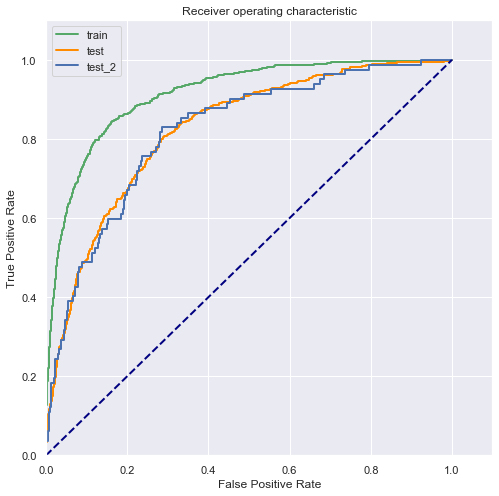

Результат после усреднения predict_proba 100 моделей:
auc_train:   0.91394
auc_test:   0.82487
auc_test_2: 0.82037
********************
Результат после усреднения auc каждой из 100 моделей:
auc_train:  0.91009
auc_test:   0.82159
auc_test_2: 0.81577
Доверительный интервал test:  (0.8178847740286607, 0.8252914037502014)
std_test:   0.01857
std_train:  0.00856
std_test_2: 0.00532


In [102]:
df_2016=df_ml.loc[lambda x: x.REQUEST_DATE<'2017-07-01'].drop('REQUEST_DATE', axis=1)
df_2018=df_ml.loc[lambda x: x.REQUEST_DATE>='2017-07-01']

plt.figure(figsize=(8, 8))
line_width = 2

fpr, tpr, thresholds = roc_curve(list(df_ml.loc[[*dict_pred_train], '12_90']), (pd.DataFrame([*dict_pred_train.values()], index=[*dict_pred_train]).apply(lambda x: x/100 if any(x.index.isin(df_2016.index)) else x/80).values))
plt.plot(fpr, tpr, color='g', lw=line_width, label='train')

fpr, tpr, thresholds = roc_curve(list(df_2018.loc[[*dict_pred_test], '12_90']), (pd.Series([*dict_pred_test.values()])/20).values)
plt.plot(fpr, tpr, color='darkorange', lw=line_width, label='test')

fpr, tpr, thresholds = roc_curve(y_test_2, [sum(i)/100 for i in list(zip(*list_pred_test_2))])
plt.plot(fpr, tpr, color='b', lw=line_width, label='test_2')

plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--')
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('Receiver operating characteristic')
plt.show()
tmp0=roc_auc_score(list(df_ml.loc[[*dict_pred_train], '12_90']), (pd.DataFrame([*dict_pred_train.values()], index=[*dict_pred_train]).apply(lambda x: x/100 if any(x.index.isin(df_2016.index)) else x/80).values))
tmp1=roc_auc_score(list(df_2018.loc[[*dict_pred_test], '12_90']), (pd.Series([*dict_pred_test.values()])/20).values)
tmp2=roc_auc_score(y_test_2, [sum(i)/100 for i in list(zip(*list_pred_test_2))])

print('Результат после усреднения predict_proba 100 моделей:')
print(f'auc_train:   {tmp0:.5f}')
print(f'auc_test:   {tmp1:.5f}')
print(f'auc_test_2: {tmp2:.5f}')
print('********************')
print('Результат после усреднения auc каждой из 100 моделей:')
print(f'auc_train:  {pd.Series(auc_train).mean():.5f}')
print(f'auc_test:   {pd.Series(auc_test).mean():.5f}')
print(f'auc_test_2: {pd.Series(auc_test_2).mean():.5f}')
print('Доверительный интервал test: ', stats_intervals(pd.Series(auc_test).mean(),pd.Series(auc_test).std(), 100))
print(f'std_test:   {pd.Series(auc_test).std():.5f}')
print(f'std_train:  {pd.Series(auc_train).std():.5f}')
print(f'std_test_2: {pd.Series(auc_test_2).std():.5f}')

In [104]:
start_time = time.time()

pred_test_yy=[]

for clf in clf_list:
    pred_test_yy.append(clf.predict_proba(x_test_2)[:,1])
    
print(time.time() - start_time)    

4.911005258560181


### Качество предсказанных значений

In [105]:
roc_auc_score(y_test_2, [sum(i)/100 for i in list(zip(*pred_test_yy))])

0.8203728915245634

## Shap (на одном из clf, на одном из train)

In [106]:
shap_values= shap.TreeExplainer(clf_lgbm).shap_values(x_train)

In [ ]:
shap.summary_plot(shap_values[0], x_train, plot_type="bar",  max_display=22, auto_size_plot=True)


In [ ]:
shap.summary_plot(shap_values[0], x_train, max_display=22, auto_size_plot=True, plot_type="dot")

## Изменчивость теста

In [110]:
start_time = time.time()

auc_test, auc_train, auc_test_2, auc_test_2_blnc = [], [], [], []
diff_test=[] 

fold=1
seeds=5  
 
kf=StratifiedKFold(n_splits=5, random_state=seeds, shuffle=True)
folds=kf.n_splits        
x_train, y_train, x_test, y_test =my_cv(df_full, kf, fold)
            
clf_lgbm_2 = lgbm.LGBMClassifier(**grid_params) 
        
clf_lgbm_2.fit(x_train, y_train, 
             eval_set=[(x_test,  y_test)], 
             eval_metric='auc',
             early_stopping_rounds=200,
             verbose=-1)

auc_test=roc_auc_score(y_test, clf_lgbm_2.predict_proba(x_test)[:,1])

for i in range(1000):
    
    clas=np.random.randint(0,2)
    del_ind=y_test.loc[lambda x: x==clas].sample(1).index[0] #Вариант с заменой 1 значения
    #x_test=x_test.loc[lambda x: ~x.index.isin(del_ind)] #Вариант с удалением 1 значения
    #y_test=y_test.loc[lambda x: ~x.index.isin(del_ind)]

    y_test.loc[del_ind]=(1-clas)           
    auc_test_2=roc_auc_score(y_test, clf_lgbm_2.predict_proba(x_test)[:,1])  
    diff_test.append(auc_test-auc_test_2)
    y_test.loc[del_ind]=clas
print('---------------------------------------------')  
print('diff_test: ', pd.Series(diff_test).mean())
print(time.time() - start_time)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1640]	valid_0's auc: 0.817777
---------------------------------------------
diff_test:  0.0019793952703952363
55.073153257369995


In [111]:
#pd.Series([auc_test - x for x in diff_test]).std()
pd.Series(diff_test).std()

0.0037719670057614983

In [112]:
pd.Series(diff_test).abs().std()+pd.Series(diff_test).abs().mean()

0.005988335451215306

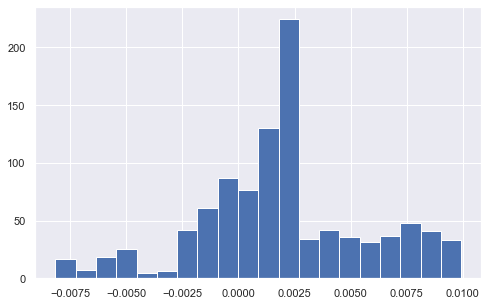

In [113]:
pd.Series(diff_test).hist(figsize=(8,5), bins=20)

In [114]:
pd.Series(diff_test).mean()

0.0019793952703952363

In [115]:
print (stats.shapiro(diff_test))

(0.9691249132156372, 9.726402083916341e-14)


## RFECV

In [222]:
df_rfe = df.copy()

In [128]:
from sklearn.utils import shuffle

df_rfe = shuffle(df_rfe, random_state=20)

In [275]:
X_new = df_rfe.loc[lambda x: x.REQUEST_DATE>='2017-07-01'].drop(['12_90','REQUEST_DATE'], axis=1)
Y_new = df_rfe.loc[lambda x: x.REQUEST_DATE>='2017-07-01']['12_90']
#X_old = df_rfe.loc[lambda x: x.REQUEST_DATE<'2017-07-01'].drop(['12_90','REQUEST_DATE'], axis=1)
#Y_old = df_rfe.loc[lambda x: x.REQUEST_DATE<'2017-07-01']['12_90']

x_train, x_test, y_train, y_test = train_test_split(X_new, Y_new, test_size = 1000, stratify=Y_new, random_state=5, shuffle = True)

#x_train=pd.concat([X_old, XX], axis=0)
#y_train=pd.concat([Y_old, YY], axis=0)

In [276]:
start_time = time.time()

clf_lgbm_3 = lgbm.LGBMClassifier(**grid_params) 
      
clf_lgbm_3.fit(x_train, y_train, 
                eval_set=[(x_test,  y_test)],
                eval_metric='auc',
                early_stopping_rounds=200,
                verbose=-1)          
print('---------------------------------------------')      
print('time: ', time.time() - start_time)    

Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1832]	valid_0's auc: 0.85333
---------------------------------------------
time:  2.1672286987304688


In [270]:
#clf_lgbm_3 = lgbm.LGBMClassifier(**grid_params) 

In [235]:
kf

StratifiedKFold(n_splits=5, random_state=5, shuffle=True)

In [285]:
from sklearn.feature_selection import RFECV

start_time = time.time()

rfecv_lgbm = RFECV(estimator=clf_lgbm_3, cv=kf, step=1, verbose=-1)
rfecv_lgbm.fit(x_train, y_train)

print(time.time() - start_time)

443.47967648506165


In [286]:
rfecv_lgbm.n_features_

21

In [273]:
rfecv_lgbm.min_features_to_select

1